In [1]:
using PyPlot

In [2]:
using LsqFit

In [3]:
alpha(r::Float64,k::Float64,l::Float64) = acos((r^2.0 + k^2.0 - l^2.0)/(2.0*k*r))    

alpha (generic function with 1 method)

In [4]:
beta(r::Float64,k::Float64,l::Float64) = acos((r^2.0 + l^2.0 - k^2.0)/(2.0*l*r))  

beta (generic function with 1 method)

In [5]:
function r(tau::Array{Float64},b::Float64,k::Float64,l::Float64,T::Float64)
    v = 2.0*sqrt((k+l)^2.0-b^2.0)/T
    return sqrt(b^2.0 .+ (v.*tau).^2.0)
end

r (generic function with 1 method)

In [6]:
tau(t::Array{Float64},P::Float64,t_n::Float64) = mod(t.-t_n+(P/2),P)-(P/2.0)

tau (generic function with 1 method)

In [7]:
function overlap(rs::Array{Float64},k::Float64,l::Float64)
    result = Float64[]
    for r in rs
        if r >= l+k
            push!(result,0.0)
        elseif r <= l-k
            push!(result,pi*k^2.0)
        else
            push!(result,(k^2.0)*(alpha(r,k,l)-cos(alpha(r,k,l))*sin(alpha(r,k,l)))+(l^2.0)*(beta(r,k,l)-cos(beta(r,k,l))*sin(beta(r,k,l))))
        end
    end
    return result
end

overlap (generic function with 1 method)

In [8]:
function transit(ts::Array{Float64},F_s::Float64,k::Float64,l::Float64,P::Float64,T::Float64,t_n::Float64,b::Float64)
    taus = tau(ts,P,t_n)
    rs = r(taus,b,k,l,T)
    overlaps = overlap(rs,k,l)
    return F_s*(1.0.-overlaps./(pi*l^2.0))
end

transit (generic function with 1 method)

In [9]:
function occultation(ts::Array{Float64},F_p::Float64,k::Float64,l::Float64,P::Float64,T::Float64,t_n::Float64,b::Float64)
    taus = tau(ts-(P/2.0),P,t_n)
    rs = r(taus,b,k,l,T)
    overlaps = overlap(rs,k,l)
    return F_p*(1.0.-overlaps./(pi*k^2.0))
end

occultation (generic function with 1 method)

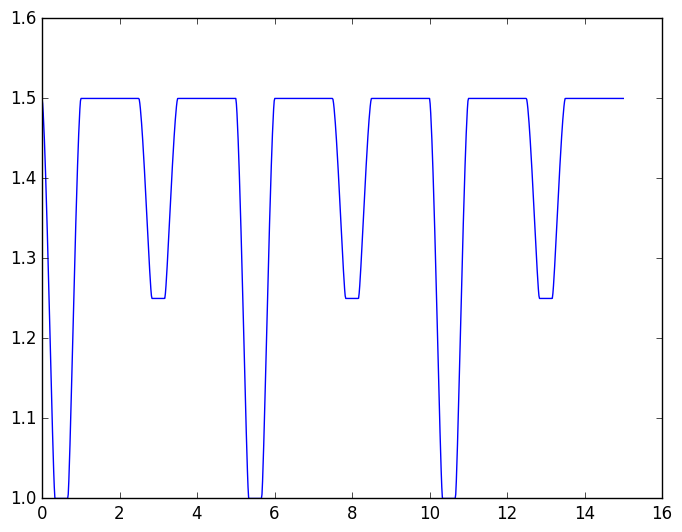

In [14]:
## test transit codes
ts = collect(linspace(0,15,1000))
F_s = 1.
F_p = 0.5
k = .5
l = 1.
P = 5.
T = 1.
t_n = 8.0
b = .0
plot(ts,transit(ts,F_s,k,l,P,T,t_n,b)+occultation(ts,F_p,k,l,P,T,t_n,b));

In [27]:
# code to determine first guess at period. should search within 1 day period around P_guess
# uses flux with ONLY transit (not second occult bc you probably wouldn't see that anyway)
function transit_P_guess(x_data::Array{Float64},y_data::Array{Float64})
    arr = hcat(x_data,y_data)
    lowest = sortrows(arr, by=x->(x[2])) #sort all points by increasing flux
    mins = sort(unique(round(lowest[1:50,1]))) #take the dimmest 50 points, sort by time rounded
    return maximum(diff(mins)) 
end

transit_P_guess (generic function with 1 method)

In [32]:
#determines a best guess for the time of transit, assume its the time of minimum flux
function transit_tn_guess(x_data::Array{Float64},y_data::Array{Float64})
    return x_data[findmin(y_data)[2]]
end

transit_tn_guess (generic function with 1 method)

In [61]:
#determines a best guess for star flux
function transit_Fs_guess(y_data::Array{Float64})
    flux_round = round(y_data)
    return median(flux_round)
end

transit_Fs_guess (generic function with 2 methods)

In [74]:
#Assume l~R_sun. Calculate a rough transit depth, which gives ratio of radii squared.
#This will give an underestimate for when b>l-k (planet disk never fully overlaps the star)
function transit_k_guess(y_data::Array{Float64},F_s::Float64)
    l = 6.96e10
    depth_guess = 1.0 - minimum(y_data)/F_s
    return sqrt(depth_guess)*l
end

transit_k_guess (generic function with 1 method)

In [ ]:
function transit_T_guess(x_data::Array{Float64},y_data::Array{Float64},P::Float64,t_n::Float64,F_s::Float64)
    #Find the time of minimum, take the average of nearest few points, go forwards/backwards in time
    #T/2 is going to be when that average is approximately F0
end

# To-do:
## Function to guess transit duration?
## Make fitting function. First fit just the transit, calculate a chi^2, then evaluate if a model with a secondary eclipse is preferred
## Finish up functions below, which plot up transit+fit, calculate density, all that good stuff

In [51]:
#phase-folds data to period P
phase_folder(x_data::Array{Float64},t_n::Float64,P::Float64) = mod(x_data-t_n, P)/P

phase_folder (generic function with 1 method)

In [60]:
function plot_transit(x_data::Array{Float64},y_data::Array{Float64},fit)
    #Outputs a phase folded normalized plot of light curve (points) with best fit (line)
    
    # need to get period and other params from fit object
    #P = fit[whatever parameter it may be]
    #t_n = fit[get central transit time]
    #T = fit[get transit duration]
    #F0 = fit[average intensity of the light curve]
    #norm_flux = y_data/F0
    #y_fit = calculate the model as a function of the parameters in fit
    
    phases = (tau(x_data,P,t_n)/P)+0.5
    fit_phases = collect(linspace(0,1,10000))
    #plot(fit_phases,model(parameters)) 
    scatter(phases, y_data/F0, alpha=0.2)
    #xlim(0.5-(0.75*T/P),0.5+(0.75*T/P))
end

plot_transit (generic function with 4 methods)

In [ ]:
function density(fit)
    # given the fit, calculate the density of the star in solar density units
    # from Seager & Mallen-Ornelas 2003
    
    # need some code here to take the fit and divy up into parameters like period, etc.
    P = fit[]
    T = fit[]
    flux = fit[]
    dflux = maximum(1-flux)
    
    Msun = 1.9891e33  # g
    Rsun = 6.955e10   # cm

    # factor to put it in units of sun
    factor = (365.25^2.0/215.^3.0)*(Msun / Rsun^3.0)
    rho = (factor/P^2.0) * ((1+sqrt(dflux))^2.0 -(b^2.0*(1-(sinpi(T/P))^2.0))/(sinpi(T/P)^2.0))^1.5
    
    #something is weird here ^ when T is really small but can't test it til we have fit params.
    
end

In [18]:
#Read in data, separate into arrays
data = readdlm("mystery_planet2.txt",Float64) 
times = data[:,1]
flux0 = data[:,2]
flux = flux0/maximum(flux0)
flux_err = data[:,3] ;

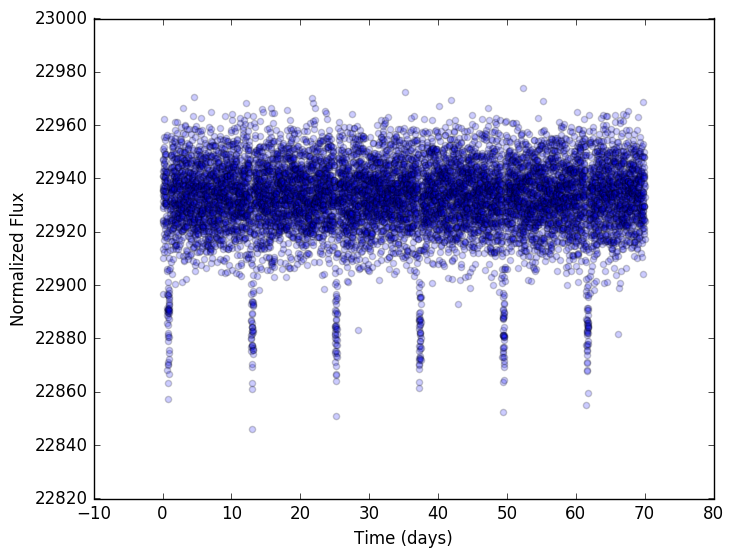

In [35]:
scatter(times, flux0, alpha=0.2)
xlabel("Time (days)")
ylabel("Normalized Flux")
#ylim(0.994,1.0005);